In [17]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [2]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0008.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [3]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

In [4]:
Furnisher("310+341+435")

In [23]:
def get_astroquery_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are "geometric","astrometric" and 
    "apparent"
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        """
        
        obj = Horizons(id = name, location = loc, epochs = t, id_type = 'majorbody')
        obj1 = obj.vectors(aberrations = cor, refplane = 'earth')
        xyz = np.array([float(obj1['x']),float(obj1['y']),float(obj1['z'])])
        uvw = np.array([float(obj1['vx']),float(obj1['vy']),float(obj1['vz'])])
        obj2 = obj.ephemerides(refsystem = 'J2000', extra_precision = True)
        radec = np.array([float(obj2['RA']),float(obj2['DEC']),float(obj1['range'])])
        return xyz,uvw,radec
    return get_target_xyz  

In [10]:
def JD_to_SpiceJD(jd):
    '''
    
    Converts jd date to spice units of time.
    
    Arguments:
    
    jd: float
    
    A jd time in days
    
    Returns:
    
    newjd: float
    
    A spice usable time in seconds
    
    
    '''
    t = Time(jd, format='jd', scale='utc')
    k = t.fits
    print(k)
    year = k[0:4]
    month = k[5:7]
    day = k[8:10]
    hours = k[11:13]
    minutes = k[14:16]
    seconds = k[17:23]
    newmnth = monthToNum(month)
    utc = newmnth + ' ' + day + ", " + year
    newjd = spice.str2et(utc) + int(hours)*3600 + int(minutes)*60 + float(seconds)
    return newjd

In [11]:
def monthToNum(shortMonth):
    
    '''
    
    Returns the name of a month that a number corresponds to and vice versa
    
    Arguments:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October)
    
    Returns:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October),
    the other one to the one that was given as an argument
    
    '''
    
    return{
        'Jan' : '01', 'Feb' : '02','Mar' : '03','Apr' : '04','May' : '05','Jun' : '06','Jul' : '07','Aug' : '08',
        'Sep' : '09', 'Oct' : '10','Nov' : '11','Dec' : '12','01' : 'Jan','02' : 'Feb','03' : 'Mar','04' : 'Apr',
        '05' : 'May','06' : 'Jun','07' : 'Jul','08' : 'Aug','09' : 'Sep', '10' : 'Oct','11' : 'Nov','12' : 'Dec'}[shortMonth]

In [21]:
obj = Horizons(id = 'Ananke', location = '5', epochs = 2450814.916666667, id_type = 'majorbody')
obj.ephemerides()


targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str12,str24,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str1,float64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64
Ananke (512),1998-Jan-01 10:00:00.000,2450814.916666667,*,m,326.73691,-15.29712,326.70377,-15.30689,30.16205,11.1808,112.2502,-1.1154,674.06,549.95,5979.428,-1505.1,104.365,16.8724515049,999,--,19.42,7.61,99.539,2.3e-05,6160.251,*,0.004903,--,--,--,--,252.51,0.0,--,--,331.5854,-2.0574,4.950677005156,1.3754834,5.62404798995453,19.7663603,46.773781,14.37827,41.46101,43.0127,/T,7.7883,8.195,9.3,61.1256,72.502,250.669,-0.25067,Cap,63.183912,323.7646294,-1.8113796,--,--,38.681014,-45.665694,10.0906810128,0.000354,--,--,--,--,--,--,--,--,--,--,--,--,--,-4.907799942,7.7841,327.69,-1.9389


In [66]:
spic = []
hors = []

get_jupsp = get_spice_function('5','NONE','0')
get_juphr = get_astroquery_function('5','geometric','g@0')
for i in range(0,100):
    spic.append(get_jupsp(JD_to_SpiceJD(2450814.916666667+100*i)))
    hors.append(get_juphr(2450814.916666667+100*i))
    print(i)
spx = []
hrx = []
spy = []
hry = []
spz = []
hrz = []
spu = []
hru = []
spv = []
hrv = []
spw = []
hrw = []
spra = []
hrra = []
spdec = []
hrdec = []
for i in range(0,100):
    spx.append(spic[i][0][0])
    hrx.append(hors[i][0][0])
    spy.append(spic[i][0][1])
    hry.append(hors[i][0][1])
    spz.append(spic[i][0][2])
    hrz.append(hors[i][0][2])
    spu.append(spic[i][1][0])
    hru.append(hors[i][1][0])
    spv.append(spic[i][1][1])
    hrv.append(hors[i][1][1])
    spw.append(spic[i][1][2])
    hrw.append(hors[i][1][2])
    spra.append(spic[i][2][0])
    hrra.append(hors[i][2][0])
    spdec.append(spic[i][2][1])
    hrdec.append(hors[i][2][1])

1998-01-01T10:00:00.000(UTC)
0
1998-04-11T10:00:00.000(UTC)
1
1998-07-20T10:00:00.000(UTC)
2
1998-10-28T10:00:00.000(UTC)
3
1999-02-05T10:00:00.000(UTC)
4
1999-05-16T10:00:00.000(UTC)
5
1999-08-24T10:00:00.000(UTC)
6
1999-12-02T10:00:00.000(UTC)
7
2000-03-11T10:00:00.000(UTC)
8
2000-06-19T10:00:00.000(UTC)
9
2000-09-27T10:00:00.000(UTC)
10
2001-01-05T10:00:00.000(UTC)
11
2001-04-15T10:00:00.000(UTC)
12
2001-07-24T10:00:00.000(UTC)
13
2001-11-01T10:00:00.000(UTC)
14
2002-02-09T10:00:00.000(UTC)
15
2002-05-20T10:00:00.000(UTC)
16
2002-08-28T10:00:00.000(UTC)
17
2002-12-06T10:00:00.000(UTC)
18
2003-03-16T10:00:00.000(UTC)
19
2003-06-24T10:00:00.000(UTC)
20
2003-10-02T10:00:00.000(UTC)
21
2004-01-10T10:00:00.000(UTC)
22
2004-04-19T10:00:00.000(UTC)
23
2004-07-28T10:00:00.000(UTC)
24
2004-11-05T10:00:00.000(UTC)
25
2005-02-13T10:00:00.000(UTC)
26
2005-05-24T10:00:00.000(UTC)
27
2005-09-01T10:00:00.000(UTC)
28
2005-12-10T10:00:00.000(UTC)
29
2006-03-20T10:00:00.000(UTC)
30
2006-06-28T10:00:0

89
2022-08-23T10:00:00.000(UTC)
90
2022-12-01T10:00:00.000(UTC)
91
2023-03-11T10:00:00.000(UTC)
92
2023-06-19T10:00:00.000(UTC)
93
2023-09-27T10:00:00.000(UTC)
94
2024-01-05T10:00:00.000(UTC)
95
2024-04-14T10:00:00.000(UTC)
96
2024-07-23T10:00:00.000(UTC)
97
2024-10-31T10:00:00.000(UTC)
98
2025-02-08T10:00:00.000(UTC)
99


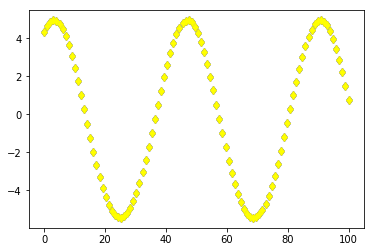

In [76]:
plt.plot(x,spx,"d",color = "blue")
plt.plot(x,hrx,"d",color = "yellow")

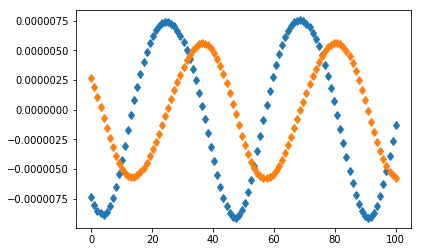

In [74]:
plt.plot(x,10**3*(np.array(spu)-np.array(hru)),"d")
plt.plot(x,(np.array(spx)-np.array(hrx)),"d")

Slightly different mean radius, spice has the lower mass.

In [75]:
np.sqrt(np.mean(spx)**2+np.mean(spy)**2+np.mean(spz)**2),np.sqrt(np.mean(hrx)**2+np.mean(hry)**2+np.mean(hrz)**2),

(0.23532260936969124, 0.2353224153694773)

In [78]:
hrx

[4.332418188930069,
 4.649220452847878,
 4.855786324953191,
 4.945873011824521,
 4.916292780047074,
 4.767123369790482,
 4.501771947302495,
 4.126880957126269,
 3.652079244367999,
 3.089597385294941,
 2.453778365075552,
 1.760523325622571,
 1.026713901473457,
 0.2696499782561907,
 -0.4934666482949476,
 -1.24598132488611,
 -1.972157404712409,
 -2.657466145570318,
 -3.288800038605134,
 -3.854618012980785,
 -4.345033854527007,
 -4.751859583787304,
 -5.068615337329353,
 -5.290515886558381,
 -5.41444242907137,
 -5.438906414252008,
 -5.364010418436736,
 -5.191409367603558,
 -4.924273796803783,
 -4.567255515582621,
 -4.126454518816659,
 -3.609384815024934,
 -3.024935402983903,
 -2.383321545178679,
 -1.696020059872795,
 -0.9756815281619174,
 -0.2360110797429075,
 0.5083905688944353,
 1.242234311640237,
 1.949804836440287,
 2.615282429500411,
 3.223124310318284,
 3.758500151170691,
 4.207768541917953,
 4.558973724161659,
 4.802333616530763,
 4.930684777523638,
 4.939846927630981,
 4.82887233062